In [1]:
import heapq

class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')

## Simulation

In [2]:
class Bus:
    """
    Simulates the individual buses.
    """
    def __init__(self, name, stops, first_stop, schedule, capacity):
        self.people_in_bus = 0
        self.stops = stops
        self.n_stops = len(stops)
        self.name = name
        self.capacity = capacity
        self.sum_people_in_bus = 0
        self.n_stops_served = 0
        self.stop = first_stop
        self.schedule = schedule
        self.people_in_bus_lst = []
        self.desired_stops = {}
        for i in range(self.n_stops):
            self.desired_stops[str(i)] = 0

        self.disembark(schedule, first_stop)

    def disembark(self, schedule, stop):
        """
        Disembarks all passengers that want to stay at this stop. 
        The time to disembark is drawn from a distribution.
        
        Triggers embark
        """
        self.stop = stop
        # Disembark everyone that wants to stay at this stop
        people_disembarking = self.desired_stops[str(stop.name)]
        self.desired_stops[str(stop.name)] -= people_disembarking
        assert self.desired_stops[str(stop.name)] == 0
        self.people_in_bus -= people_disembarking
        self.people_in_bus_lst.append((schedule.now, self.people_in_bus))

        # Trigger embark
        time_to_disembark = sts.norm(0.03 * people_disembarking,
                                     0.01 * people_disembarking**0.5).rvs()
        schedule.add_event_after(time_to_disembark, self.embark, stop)

    def embark(self, schedule, stop):
        """
        Embarks the maximum number of passengers within the capacity of the bus.
        
        The method also calculates the waiting times of the passengers and keeps track of 
        the desired stop of each. 
        
        Schedules disembark at the next stop
        """
        # Embark the maximum number of people that doesn't surpass bus capacity
        people_embarking = min(self.capacity - self.people_in_bus,
                               stop.people_in_queue)

        # Compute waiting time
        if people_embarking != 0:
            waiting_times = schedule.now - np.array(stop.queue[:people_embarking])
            stop.sum_waiting_time += sum(waiting_times)

        # Updating stats
        stop.bus_arrival_times.append(schedule.now)
        stop.people_in_queue -= people_embarking
        stop.people_in_queue_lst.append((schedule.now, stop.people_in_queue))
        stop.queue = stop.queue[people_embarking:]
        stop.people_served += people_embarking
        self.people_in_bus += people_embarking
        self.people_in_bus_lst.append((schedule.now, self.people_in_bus))
        
        

        # Registering how full the bus is for metric
        self.sum_people_in_bus += self.people_in_bus
        self.n_stops_served += 1

        # Passengers decide where they want to go
        for passenger in range(people_embarking):
            desired_stop = random.choice([(stop.name + i) % self.n_stops
                                          for i in range(1, 7)])
            self.desired_stops[str(desired_stop)] += 1

        # Trigger disembark at next stop
        time_to_embark = sts.norm(0.05 * people_embarking,
                                  0.01 * people_embarking**0.5).rvs()
        time_to_ride = sts.norm(2, .5).rvs()
        next_stop = self.stops[(stop.name + 1) % self.n_stops]
        schedule.add_event_after(time_to_embark + time_to_ride, self.disembark,
                                 next_stop)
        
    def plot_capacity(self):
        """
        Plots the percentage of available seats in the bus over time
        """
        time, people_in_bus = zip(*self.people_in_bus_lst)
        pct_capacity = np.array(people_in_bus) / self.capacity * 100
        plt.plot(time, pct_capacity, "k")
        plt.title(f"Bus {self.name + 1} capacity over time")
        plt.ylabel("Seats occupied %")
        plt.xlabel("Time (minutes)")

class Stop:
    """
    Simulates the individual bus stops.
    """
    def __init__(self, name, arrival_distribution, schedule, t=None):
        self.name = name
        self.t = t
        self.arrival_distribution = arrival_distribution
        if t != None:
            self.alt_distribution = sts.expon(scale=1/(1.2+math.cos(math.pi*(self.t-7)/6)))
        self.people_in_queue = 0
        self.total_people = 0
        self.people_served = 0
        self.sum_arrival_time = 0
        self.sum_waiting_time = 0
        self.max_queue = 0
        self.annoyed = 0
        self.arrival_times = []
        self.bus_arrival_times = []
        self.people_in_queue_lst = [(0, 0)]
        self.max_queue_lst = [(0,0)]
        self.queue = []
        self.add_customer(schedule)
        

    def add_customer(self, schedule):
        """
        Adds a customer to the stop and schedules the next customer arrival.
        The next arrival time is drawn from self.distribution
        
        Extension: schedules an annoyance check after 10 minutes
        """
        # Add the customer to the queue
        self.total_people += 1
        self.people_in_queue += 1
        self.queue.append(schedule.now)

        # Update stats
        if self.people_in_queue > self.max_queue:
            self.max_queue = self.people_in_queue
            self.max_queue_lst.append((schedule.now, self.max_queue))
            
        self.sum_arrival_time += schedule.now
        self.arrival_times.append(schedule.now)
        self.people_in_queue_lst.append((schedule.now, self.people_in_queue))

        # Schedule new arrival
        if self.t == None:
            schedule.add_event_after(self.arrival_distribution.rvs(),
                                 self.add_customer)
        
        else:
            schedule.add_event_after(self.alt_distribution.rvs(),
                                 self.add_customer)
            schedule.add_event_after(10, self.check_annoyance, schedule.now)
            
        
    def check_annoyance(self, schedule, arrival_time):
        """
        Checks if a customer is annoyed. 
        If there are more than 20 people in front of the customer, removes them from the queue. 
        Uses the arrival_time as a unique customer identification.
        """       
        if len(self.queue)>20:
            if self.queue[20] < arrival_time:
                self.people_in_queue -= 1
                self.annoyed += 1
                self.queue.remove(arrival_time)
        
    
    def plot_arrival_distribution(self, bins=10):
        """
        Plots the comparison of arrival intervals with the theoretical arrival intervals
        """
        distances = np.diff(self.arrival_times)
        n = len(distances)
        plt.hist(distances, density=True, bins = bins, color = "k", label = "empirical results")
        i = max(distances)/bins/2
        x = np.linspace(i, max(distances)-i, bins)
        plt.plot(x, sts.expon(scale=1).pdf(x), '-', color = 'red', label='theoretical value')
        plt.title("Theoretical and empirical arrival intervals")
        plt.xlabel("Interval between arrivals (minutes)")
        plt.ylabel("Probability")
        plt.legend()
        
    
    def plot_people_in_queue(self):
        """
        Plots the number of people in the stop over time
        """
        time, n_people = zip(*self.people_in_queue_lst)
        plt.plot(time, n_people, 'k')
        plt.title(f"Number of people in queue {self.name} over time")
        plt.ylabel("People in queue")
        plt.xlabel("Time since midnight (minutes)")
        

class BusSystem:
    """
    Hods all bus stops and buses, triggers the events in the simulation.
    """
    def __init__(self,
                 n_stops,
                 n_buses,
                 arrival_distribution,
                 schedule,
                 capacity=130,
                 t = None):
        self.n_stops = n_stops
        self.stops = [
            Stop(i, arrival_distribution, schedule, t = t) for i in range(n_stops)
        ]
        self.n_buses = n_buses
        self.buses = [
            Bus(name=i,
                stops=self.stops,
                first_stop=self.stops[self.n_stops // self.n_buses * i],
                schedule=schedule,
                capacity=capacity) for i in range(n_buses)
        ]
        self.people_in_system = 0
        self.capacity = capacity
        self.schedule = schedule

    def run(self, run_until, schedule=None):
        """
        Runs the simulation by until the desired time
        """
        if schedule == None:
            schedule = self.schedule
        while schedule.next_event_time() < run_until:
            schedule.run_next_event()

    def current_state(self):
        """
        Prints the number of people in each stop
        """
        for stop in self.stops:
            print(f"Stop {stop.name}:{stop.people_in_queue} people in queue")
            



def run_simulation(arrival_distribution, n_buses, run_until, capacity=130, t = None):
    schedule = Schedule()
    bus_system = BusSystem(15, n_buses, arrival_distribution, schedule, t=t)
    bus_system.run(run_until)
    return bus_system

In [3]:
import scipy.stats as sts
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import math

bussystem = run_simulation(sts.expon(scale=1), 1, 500)

In [4]:
bussystem.current_state()

Stop 0:243 people in queue
Stop 1:248 people in queue
Stop 2:262 people in queue
Stop 3:300 people in queue
Stop 4:315 people in queue
Stop 5:282 people in queue
Stop 6:237 people in queue
Stop 7:241 people in queue
Stop 8:242 people in queue
Stop 9:321 people in queue
Stop 10:254 people in queue
Stop 11:275 people in queue
Stop 12:233 people in queue
Stop 13:221 people in queue
Stop 14:246 people in queue


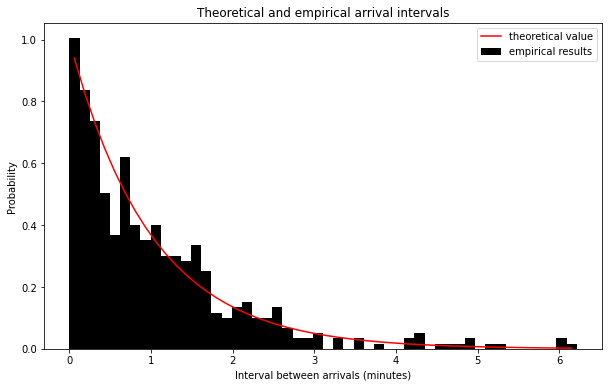

In [5]:
plt.figure(figsize=(10,6))
bussystem.stops[0].plot_arrival_distribution(bins=50)

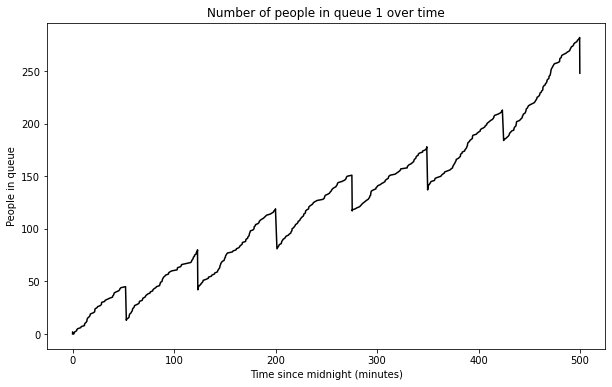

In [6]:
plt.figure(figsize=(10,6))
bussystem.stops[1].plot_people_in_queue()

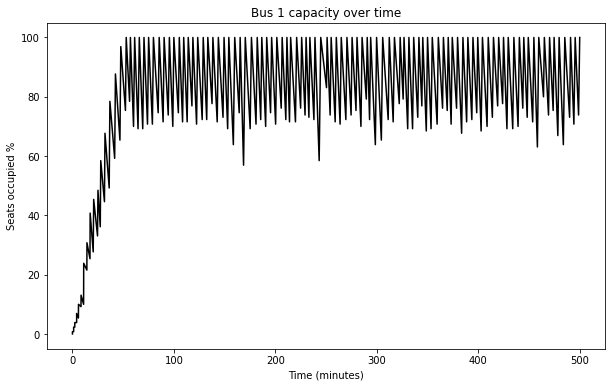

In [7]:
plt.figure(figsize=(10,6))
bussystem.buses[0].plot_capacity()

In [8]:
def run_experiment_extension(n_bus_lst, run_until, num_trials, t=None):
    '''
    Run an experiment with different arrival rates for an M/G/1 queue. By
    setting the service time distribution appropriately, you can also simulate
    M/D/1 and M/M/1 queues.
    '''

    # We record only the mean and standard error of the mean for each experiment
    annoyed_mean = []
    annoyed_std_err = []

    for n_bus in tqdm(n_bus_lst):
        annoyed_lst = []
        for trial in range(num_trials):
            bus_system = run_simulation(arrival_distribution, n_bus, run_until, t=t)
            
            # Probability of getting annoyed
            sum_annoyed = sum([stop.annoyed for stop in bus_system.stops])
            sum_served = sum([stop.people_served for stop in bus_system.stops])
            p_annoyed = sum_annoyed/(sum_annoyed+sum_served)
            annoyed_lst.append(p_annoyed)
            
        annoyed_mean.append(np.mean(annoyed_lst))
        annoyed_std_err.append(sts.sem(annoyed_lst))

    # Convert lists to arrays so we can easily add, subtract, and multiply them
    annoyed_mean = np.array(annoyed_mean)
    annoyed_std_err = np.array(annoyed_std_err)

    return annoyed_mean, annoyed_std_err

In [9]:
def run_experiment(n_bus_lst, run_until, num_trials, t=None):
    '''
    Run an experiment with different arrival rates for an M/G/1 queue. By
    setting the service time distribution appropriately, you can also simulate
    M/D/1 and M/M/1 queues.
    '''

    # We record only the mean and standard error of the mean for each experiment
    wait_mean = []
    wait_std_err = []

    max_queue_mean = []
    max_queue_std_err = []

    capacity_mean = []
    capacity_std_err = []

    annoyed_mean = []
    annoyed_std_err = []

    for n_bus in tqdm(n_bus_lst):
        arrival_distribution = sts.expon(scale=1)
        avg_wait_times = []
        max_queue_lst = []
        pct_capacity_lst = []
        annoyed_lst = []
        for trial in range(num_trials):
            bus_system = run_simulation(arrival_distribution,
                                        n_bus,
                                        run_until,
                                        t=t)
            

            # Average waiting time
            sum_waits = sum(
                [stop.sum_waiting_time for stop in bus_system.stops])
            sum_served = sum([stop.people_served for stop in bus_system.stops])
            avg_wait_time = sum_waits / sum_served
            avg_wait_times.append(avg_wait_time)

            # Max queue
            max_queue = np.max([stop.max_queue for stop in bus_system.stops])
            max_queue_lst.append(max_queue)

            # Bus capacity percentage
            pct_capacity = np.mean([
                bus.sum_people_in_bus / bus.n_stops_served
                for bus in bus_system.buses
            ]) / bus_system.capacity * 100
            pct_capacity_lst.append(pct_capacity)

            # Probability of getting annoyed
            sum_annoyed = sum([stop.annoyed for stop in bus_system.stops])
            sum_served = sum([stop.people_served for stop in bus_system.stops])
            p_annoyed = sum_annoyed / (sum_annoyed + sum_served)
            annoyed_lst.append(p_annoyed)

        wait_mean.append(np.mean(avg_wait_times))
        wait_std_err.append(sts.sem(avg_wait_times))

        max_queue_mean.append(np.mean(max_queue_lst))
        max_queue_std_err.append(sts.sem(max_queue_lst))

        capacity_mean.append(np.mean(pct_capacity_lst))
        capacity_std_err.append(sts.sem(pct_capacity_lst))

        annoyed_mean.append(np.mean(annoyed_lst))
        annoyed_std_err.append(sts.sem(annoyed_lst))

    # Convert lists to arrays so we can easily add, subtract, and multiply them
    wait_mean = np.array(wait_mean)
    wait_std_err = np.array(wait_std_err)

    max_queue_mean = np.array(max_queue_mean)
    max_queue_std_err = np.array(max_queue_std_err)

    capacity_mean = np.array(capacity_mean)
    capacity_std_err = np.array(capacity_std_err)

    annoyed_mean = np.array(annoyed_mean)
    annoyed_std_err = np.array(annoyed_std_err)

    return wait_mean, wait_std_err, max_queue_mean, max_queue_std_err, capacity_mean, capacity_std_err, annoyed_mean, annoyed_std_err


def make_error_plot(n_buses, mean, std_err, title, ylabel):
    '''
    Plot the empirical mean and 95% confidence interval of the mean of the queue
    length. Also plot the theoretical value for the average queue length using the
    supplied theoretical function (a function of rho).
    '''

    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.xlabel('Number of buses')
    plt.ylabel(ylabel)

    plt.errorbar(n_buses,
                 mean,
                 1.96 * std_err,
                 color='black',
                 marker='o',
                 capsize=5,
                 linestyle='--',
                 linewidth=1)

    plt.show()

In [10]:
# Run the bus experiment

n_bus_lst = np.array([i for i in range(1, 10)])  # lambda
run_until = 200
num_trials = 10

wait_mean, wait_std_err, max_queue_mean, max_queue_std_err, capacity_mean, capacity_std_err, annoyed_mean, annoyed_std_err = run_experiment(
    n_bus_lst, run_until, num_trials)
print('Bus experiment complete')

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:17<00:00, 15.30s/it]

Bus experiment complete


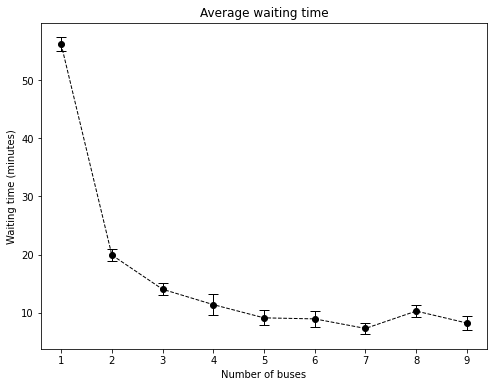

In [11]:
make_error_plot(n_bus_lst, wait_mean, wait_std_err, "Average waiting time", "Waiting time (minutes)")

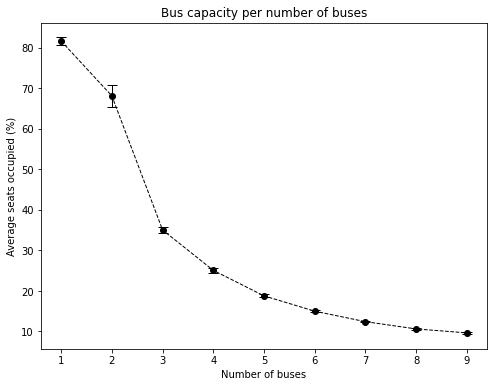

In [12]:
make_error_plot(n_bus_lst, capacity_mean, capacity_std_err, "Bus capacity per number of buses", "Average seats occupied (%)")

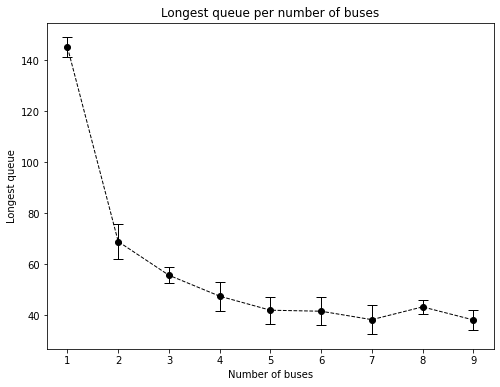

In [13]:
make_error_plot(n_bus_lst, max_queue_mean, max_queue_std_err, "Longest queue per number of buses", "Longest queue")

In [14]:
n_bus_lst = np.array([i for i in range(1, 6)])  
run_until = 100
num_trials = 10
hours = [t for t in range(0,24)]
results = []

for t in hours:
    wait_mean, wait_std_err, max_queue_mean, max_queue_std_err, capacity_mean, capacity_std_err, annoyed_mean, annoyed_std_err = run_experiment(
    n_bus_lst, run_until, num_trials, t=t)
    results.append([wait_mean, wait_std_err, max_queue_mean, max_queue_std_err, capacity_mean, capacity_std_err, annoyed_mean, annoyed_std_err])

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.50s/it]


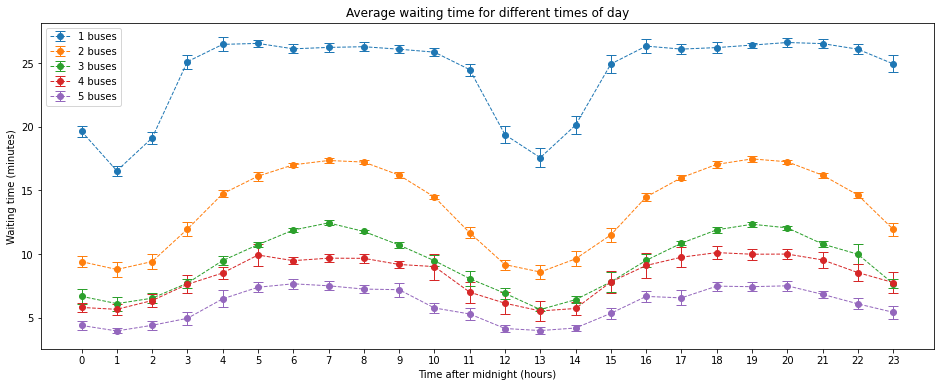

In [15]:
# Plotting average waiting time for different times of day

plt.figure(figsize = (16,6))

for i in range(len(n_bus_lst)):
    plt.errorbar(hours,
                     np.array(results)[:,0,i] ,
                     1.96 * np.array(results)[:,1,i],
                     marker='o',
                     capsize=5,
                     linestyle='--',
                     linewidth=1,
                     label = f"{i+1} buses")
    
plt.title("Average waiting time for different times of day")
plt.ylabel("Waiting time (minutes)")
plt.xlabel("Time after midnight (hours)")
plt.xticks(hours)
plt.legend()

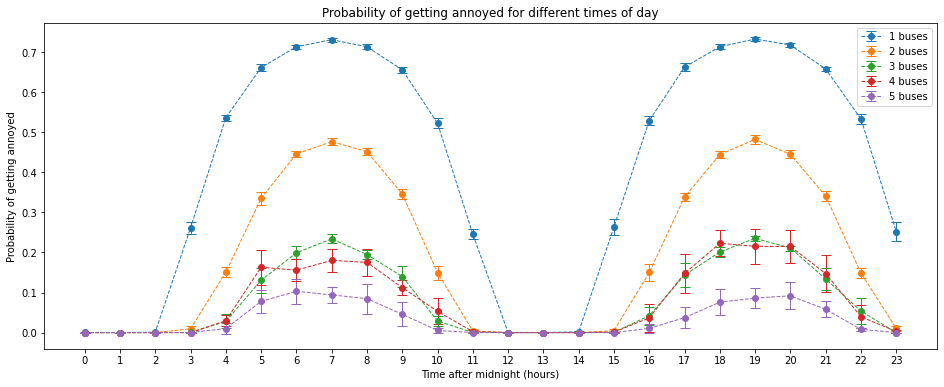

In [16]:
# Plotting probability of getting annoyed for different times of day

plt.figure(figsize = (16,6))
for i in range(len(n_bus_lst)):
    plt.errorbar(hours,
                     np.array(results)[:,-2,i] ,
                     1.96 * np.array(results)[:,-1,i],
                     marker='o',
                     capsize=5,
                     linestyle='--',
                     linewidth=1,
                     label = f"{i+1} buses")
    
plt.title("Probability of getting annoyed for different times of day")
plt.ylabel("Probability of getting annoyed")
plt.xlabel("Time after midnight (hours)")
plt.xticks(hours)
plt.legend()